In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

## load and pre-process data

In [2]:
# load data from csv
df = pd.read_csv('../Data/Smarket.csv')

# convert string to numeric for logistic regression
df.loc[df.Direction == 'Up', 'Direction2'] = 1
df.loc[df.Direction == 'Down', 'Direction2'] = 0

# divide data into train and test
df_train = df[df.Year < 2005]
df_test = df[df.Year >= 2005]

df.head(10)

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1.0
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1.0
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0.0
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1.0
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1.0
5,6,2001,0.213,0.614,-0.623,1.032,0.959,1.3491,1.392,Up,1.0
6,7,2001,1.392,0.213,0.614,-0.623,1.032,1.4450,-0.403,Down,0.0
7,8,2001,-0.403,1.392,0.213,0.614,-0.623,1.4078,0.027,Up,1.0
8,9,2001,0.027,-0.403,1.392,0.213,0.614,1.1640,1.303,Up,1.0
9,10,2001,1.303,0.027,-0.403,1.392,0.213,1.2326,0.287,Up,1.0


## very brief EDA 

In [3]:
df.describe()

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction2
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000
mean,625.500000,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,0.518400
std,360.988227,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,0.499861
min,1.000000,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,0.000000
25%,313.250000,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,0.000000
50%,625.500000,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,1.000000
75%,937.750000,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,1.000000
max,1250.000000,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000,1.000000


In [4]:
df.corr()  # non-numeric variables are ignored 

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction2
Unnamed: 0,1.000000,0.979773,0.035415,0.036022,0.038989,0.041437,0.035025,0.546348,0.035273,0.081433
Year,0.979773,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095,0.074608
Lag1,0.035415,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155,-0.039757
Lag2,0.036022,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250,-0.024081
Lag3,0.038989,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448,0.006132
Lag4,0.041437,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900,0.004215
Lag5,0.035025,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860,0.005423
Volume,0.546348,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592,0.022951
Today,0.035273,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000,0.730563
Direction2,0.081433,0.074608,-0.039757,-0.024081,0.006132,0.004215,0.005423,0.022951,0.730563,1.000000


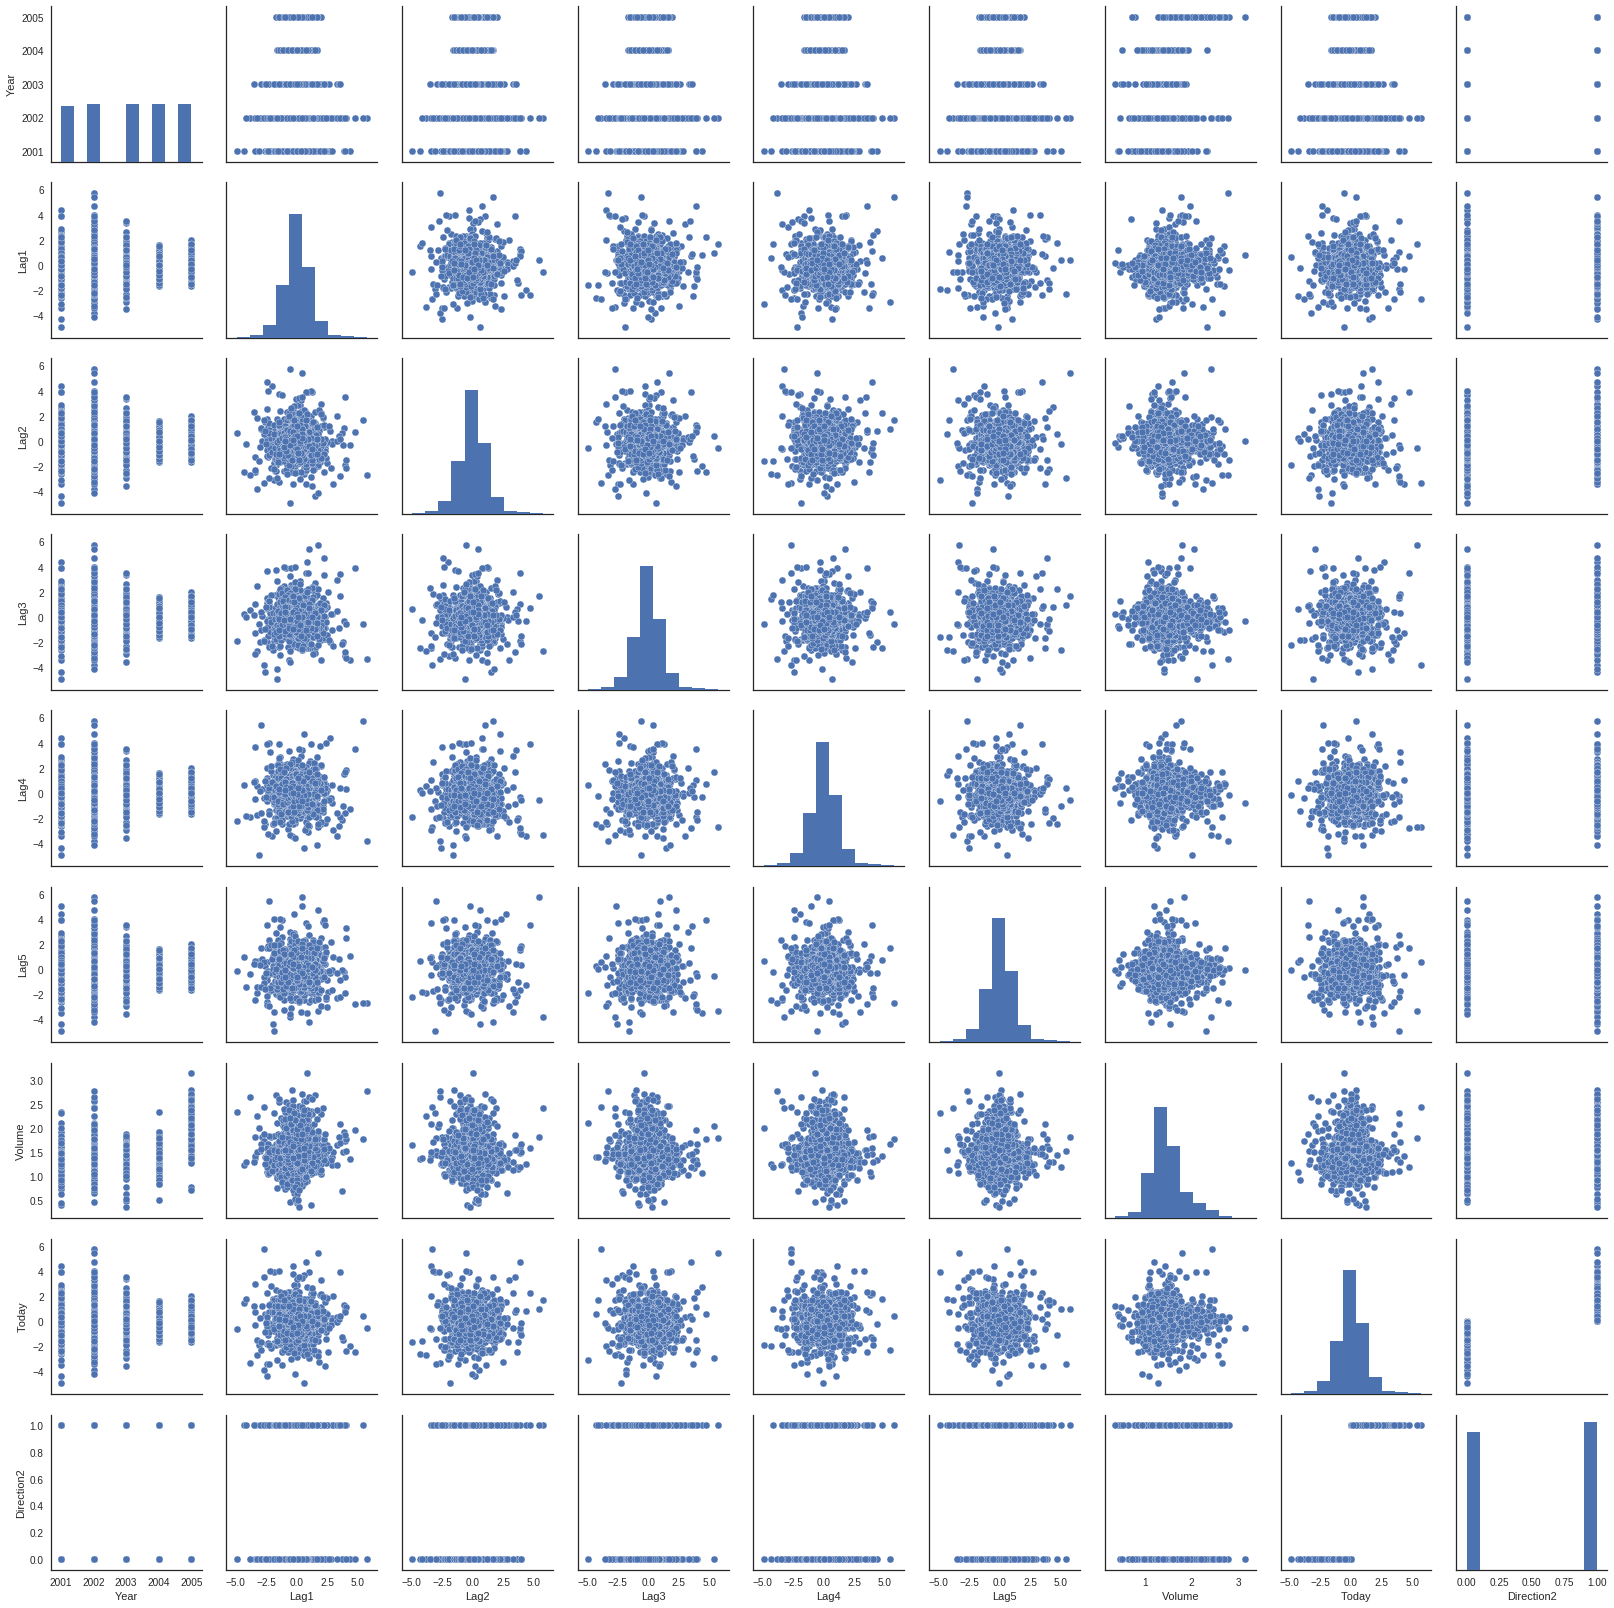

In [5]:
sns.pairplot(df[['Year','Lag1','Lag2','Lag3','Lag4','Lag5','Volume','Today','Direction2']]);

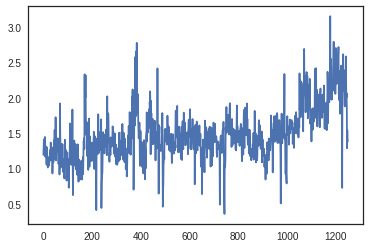

In [6]:
plt.plot(df['Volume'])

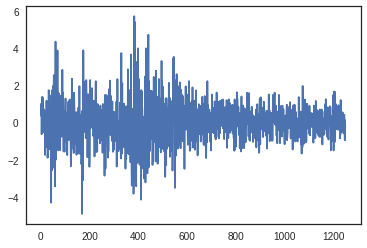

In [7]:
plt.plot(df['Lag1'])

## logistic regression

### fit the data and show a model summary

In [8]:
X_train = sm.add_constant(df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
y = df['Direction2']
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-0.126000,0.240737,-0.523394,0.600700,-0.597836,0.345836
Lag1,-0.073074,0.050168,-1.456583,0.145232,-0.171401,0.025254
Lag2,-0.042301,0.050086,-0.844568,0.398352,-0.140469,0.055866
Lag3,0.011085,0.049939,0.221974,0.824334,-0.086793,0.108963
Lag4,0.009359,0.049974,0.187275,0.851445,-0.088589,0.107307
Lag5,0.010313,0.049512,0.208296,0.834998,-0.086728,0.107354
Volume,0.135441,0.158361,0.855266,0.392404,-0.174941,0.445822


### predict

In [9]:
pred_y = est.predict()
pred_y

array([ 0.50708413,  0.48146788,  0.48113883, ...,  0.5392683 ,
        0.52611829,  0.51791656])

### create confusion matrix

In [10]:
df['pred_Direction2'] = pred_y
df['pred_Direction'] = 'Down'
df.loc[df.pred_Direction2 > .5, 'pred_Direction'] = 'Up'

In [11]:
df

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2,pred_Direction2,pred_Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up,1.0,0.507084,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up,1.0,0.481468,Down
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down,0.0,0.481139,Down
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up,1.0,0.515222,Up
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up,1.0,0.510781,Up
5,6,2001,0.213,0.614,-0.623,1.032,0.959,1.34910,1.392,Up,1.0,0.506956,Up
6,7,2001,1.392,0.213,0.614,-0.623,1.032,1.44500,-0.403,Down,0.0,0.492651,Down
7,8,2001,-0.403,1.392,0.213,0.614,-0.623,1.40780,0.027,Up,1.0,0.509229,Up
8,9,2001,0.027,-0.403,1.392,0.213,0.614,1.16400,1.303,Up,1.0,0.517614,Up
9,10,2001,1.303,0.027,-0.403,1.392,0.213,1.23260,0.287,Up,1.0,0.488838,Down


In [12]:
df_ = pd.DataFrame({'True': df.Direction,
                    'Prediction': df.pred_Direction})

df_.groupby(['Prediction','True']).size().unstack('True')

True,Down,Up
Prediction,,
Down,145,141
Up,457,507


## logistic regression with train and test set approach

In [13]:
X_train = sm.add_constant(df_train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
y = df_train['Direction2']
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.191213,0.333691,0.573024,0.566629,-0.462809,0.845234
Lag1,-0.054178,0.051786,-1.046205,0.295466,-0.155676,0.047319
Lag2,-0.045805,0.051797,-0.884324,0.376522,-0.147326,0.055715
Lag3,0.007200,0.051644,0.139418,0.889120,-0.094021,0.108421
Lag4,0.006441,0.051706,0.124568,0.900866,-0.094900,0.107782
Lag5,-0.004223,0.051138,-0.082573,0.934191,-0.104452,0.096007
Volume,-0.116257,0.239619,-0.485174,0.627553,-0.585901,0.353387


In [14]:
X_test = sm.add_constant(df_test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
pred_y = est.predict(X_test)
pred_y

998     0.528220
999     0.515669
1000    0.522652
1001    0.513854
1002    0.498334
1003    0.501091
1004    0.502770
1005    0.509568
1006    0.504011
1007    0.510641
1008    0.510118
1009    0.481165
1010    0.505295
1011    0.523632
1012    0.516836
1013    0.512533
1014    0.498218
1015    0.488277
1016    0.496014
1017    0.505188
1018    0.491069
1019    0.478976
1020    0.491258
1021    0.505624
1022    0.488910
1023    0.496766
1024    0.508446
1025    0.516825
1026    0.507317
1027    0.486840
          ...   
1220    0.487587
1221    0.465133
1222    0.459637
1223    0.476493
1224    0.470442
1225    0.480256
1226    0.521215
1227    0.499203
1228    0.491993
1229    0.485818
1230    0.461109
1231    0.471454
1232    0.484202
1233    0.490113
1234    0.490612
1235    0.491699
1236    0.489835
1237    0.487748
1238    0.470732
1239    0.474170
1240    0.482383
1241    0.479741
1242    0.494615
1243    0.495601
1244    0.483287
1245    0.483637
1246    0.506048
1247    0.5166

In [15]:
df_test['pred_Direction2'] = pred_y
df_test['pred_Direction'] = 'Down'
df_test.loc[df_test.pred_Direction2 > .5, 'pred_Direction'] = 'Up'

df_ = pd.DataFrame({'True': df_test.Direction,
                    'Prediction': df_test.pred_Direction})

df_.groupby(['Prediction','True']).size().unstack('True')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

True,Down,Up
Prediction,,
Down,77,97
Up,34,44


## logistic regression using two promising variables

In [16]:
df_train = df[df.Year < 2005]
df_test = df[df.Year >= 2005]

X_train = sm.add_constant(df_train[['Lag1', 'Lag2']])
y = df_train['Direction2']
est = smf.Logit(y, X_train).fit()

X_test = sm.add_constant(df_test[['Lag1', 'Lag2']])
pred_y = est.predict(X_test)

df_test['pred_Direction2'] = pred_y
df_test['pred_Direction'] = 'Down'
df_test.loc[df_test.pred_Direction2 > .5, 'pred_Direction'] = 'Up'

df_ = pd.DataFrame({'True': df_test.Direction,
                    'Prediction': df_test.pred_Direction})

df_.groupby(['Prediction','True']).size().unstack('True')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


True,Down,Up
Prediction,,
Down,35,35
Up,76,106


In [17]:
print(est.predict([1.0, 1.2, 1.5]))
print(est.predict([1.0, 1.1, -0.8]))

[ 0.47470706]
[ 0.50165591]
